In [18]:
!pip install -r requirements.txt

In [19]:
import fitz
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np


In [20]:
pdf_document = "keppel-corporation-limited-annual-report-2018.pdf"
doc = fitz.open(pdf_document)
page_number = 11
page = doc.loadPage(page_number)
pagetext = page.getText("text")
print(pagetext)

While pursuing new markets and opportunities, 
we are growing our stable and recurring income 
from the quality operations and maintenance 
services provided by Infrastructure Services. 
Keppel Electric has been the largest electricity 
retailer in Singapore in terms of market share in 
the commercial and industrial sector. Following 
the launch of the Open Electricity Market (OEM) 
in Singapore, Keppel Electric is also making 
headway into the housing electricity market. 
Starting from 1 November 2018, the OEM is 
being progressively extended to all consumers 
across Singapore by zones. The response to 
Keppel Electric’s retail offerings for households 
has been encouraging, with preliminary 
results showing that it is among the retailers 
with the largest market shares in the OEM. 
Keppel T&T is scaling up its logistics and 
data centre solutions to tap opportunities 
created by the fast-growing digital economy. 
With the burgeoning growth of cloud service 
providers as well as incre

In [21]:
'''
getTextBlocks will return the following from a page
xstart,ystart,xend,yend,text of each paragraph in the page.
It also gives a value (0 or 1) which says that the given entity is a paragraph or Image 1 being image.
'''
coordinates=page.getTextBlocks()
text_df=pd.DataFrame(coordinates)
text_df.drop([5],axis=1,inplace=True)
text_df.columns = ['x0','y0','x2','y2','Text','is_Image']

In [22]:
'''
Create list of image Rectangles: lst_lst
'''
image_df=text_df[text_df['is_Image']==1]
image_df['cord']=image_df.apply(lambda x:[float(x[0]),float(x[1]),float(x[2]),float(x[3])],axis=1)
lst_lst=image_df['cord'].values.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



In [23]:
def within(lst_lst,x):
  '''
  Checks whether the given box(x) lies within any of the given list of rectangles(lst_lst).
  '''
  for lst in lst_lst:
    if x[0]>=lst[0] and x[1]>=lst[1] and x[2]<=lst[2] and x[3]<=lst[3]:
      return True
  return False


In [24]:
'''
Remove the rows that have image details.
Create a new column which tells us whether the given paragraph is inside image or not.
Create a list which has the xstart values of all images and paragraphs inside images: removed_col_start
Remove the paragraphs which are inside image.
'''
text_df=text_df[text_df['is_Image']!=1]
text_df['Text_in_image']=text_df.apply(lambda x:within(lst_lst,[float(x['x0']),float(x['y0']),float(x['x2']),float(x['y2'])]),axis=1)

removed = text_df[text_df['Text_in_image']==True]
removed_col_start = removed['x0'].values.tolist()
removed_col_start.extend(image_df['x0'].values.tolist())

text_df=text_df[text_df['Text_in_image']==False]
text_df.drop(columns=['is_Image','Text_in_image'],axis=1, inplace=True)

In [25]:
'''
List of unique starting points of various paragraphs.
Each point represents a text column as starting point of paragraphs/lines in text column is unique.
'''
unique_start_points = text_df['x0'].value_counts().index.tolist()

In [26]:
'''
get_text_words will give the list of all words in the page along with co-ordinates.
removing words that are there inside image.
'''
words_bb = page.get_text_words()
print(len(words_bb))
words_bb = [x for x in words_bb if not within(lst_lst,[x[0],x[1],x[2],x[3]])]
print(len(words_bb))

715
714


In [27]:
'''
For all the unique start points, we're getting the line end co-ordinates.
'''

line_end_dict = {pt:[] for pt in unique_start_points}
prev = None
prev_start_point = min(unique_start_points)
line = ''
for i in words_bb:
  if i[0] in unique_start_points:
    if prev is not None:
      line_end_dict[prev_start_point].append(prev)
      prev_start_point = i[0]
      prev = i[2]
    else:
      continue
  else:
    prev = i[2]

line_end_dict[prev_start_point].append(prev)  

'''
creating a list xmax for each column (from each line end x-coordinate of that text column)
and also count the no. of lines in each text column
'''
max_column_end = {i:max(line_end_dict[i]) for i in line_end_dict}
n_lines_column = {i:len(line_end_dict[i]) for i in line_end_dict}


In [28]:
'''
removing text columns that has no more than 1 line. (Can be header or Footer)
'''
cols_to_keep=text_df.columns.tolist()
text_df['column_end'] = text_df['x0'].apply(lambda x: max_column_end[x])
text_df['n_lines'] = text_df['x0'].apply(lambda x: n_lines_column[x])
column_df = text_df.groupby(['x0']).agg({'column_end':'max','n_lines':'max'}).reset_index()
column_df['column_width'] = column_df['column_end']-column_df['x0']
column_df = column_df[column_df['n_lines']>1]
text_df = pd.merge(text_df,column_df,on=['x0'],how='inner')
cols_to_keep.extend(['column_width','n_lines_x'])
text_df = text_df[cols_to_keep]

In [29]:
'''
Creating list of all line lengths
'''
total_line_lengths = []
for i in line_end_dict:
  if i in column_df['x0'].values.tolist():
    list_col = [abs(x-i) for x in line_end_dict[i]]
    total_line_lengths.extend(list_col)


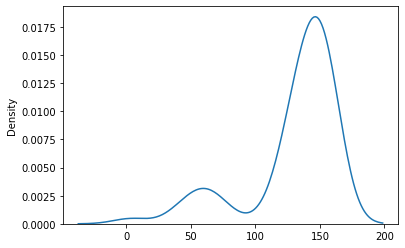

In [30]:
'''
Looks like there are few lines with less column width than usual...
We can do some kind of clustering to remove the undesired ones
'''
sns.kdeplot(total_line_lengths)


In [31]:
''''
Taking the line lengths and apply standard scaler to it and then fit DBSCAN to this...
Taking the class that has max points (Assumption is the desired text columns will have more lines compared to the undesired text columns).
Now setting the threshold of min line length in all the lines that belongs to class that has max no.of lines.
'''
data = np.array(total_line_lengths)
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1,1))
model = DBSCAN(min_samples=5)
class_ = model.fit_predict(data)
lengths = pd.DataFrame()
lengths['Length'] = total_line_lengths
lengths['class'] = class_
class_max_points = lengths['class'].value_counts().index.values[0]
min_value_threshold_for_col = lengths[lengths['class']==class_max_points].min().values[0]


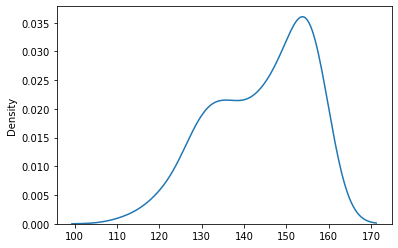

In [32]:
'''
This looks a bit better than the previous plot.
'''
sns.kdeplot([x for x in total_line_lengths if x>min_value_threshold_for_col])

In [33]:
'''
Now removing all the paragraphs that has lesser max width than the threshold.
Sort the table by x0 and y0
'''
text_df = text_df[text_df['column_width']>min_value_threshold_for_col]
text_df.sort_values(['x0','y0'],inplace=True)

In [34]:
text_df['Text'].to_csv('text_in_page.csv',index=False)